In [1]:
from sklearn.metrics import roc_auc_score
import pandas as pd

In [54]:
phi_df = pd.read_csv(
        'mmlu_pro_stem_w_filtered_numerical_maj_w_entropyphi4.tsv',
        sep="\t",
        header=0,
        escapechar="\\",
    )
phi_df

phi_df.loc[phi_df['entropy_ans_correct_phi3'] == True, 'entropy_ans_correct_phi3'] = 1
phi_df.loc[phi_df['entropy_ans_correct_phi3'] == False, 'entropy_ans_correct_phi3'] = 0

C:\Users\danie\AppData\Local\Temp\ipykernel_30668\1554910116.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  phi_df.loc[phi_df['entropy_ans_correct_phi3'] == True, 'entropy_ans_correct_phi3'] = 1


In [43]:
mistral_df = pd.read_csv(
        '__mmlu_entropy_mistral.tsv',
        sep="\t",
        header=0,
        escapechar="\\",
    )
mistral_df.loc[mistral_df['entropy_ans_correct_mistral'] == True, 'entropy_ans_correct_mistral'] = 1
mistral_df.loc[mistral_df['entropy_ans_correct_mistral'] == False, 'entropy_ans_correct_phi3'] = 0

# Ensure the target variable is in the correct format
mistral_df['entropy_ans_correct_mistral'] = mistral_df['entropy_ans_correct_mistral'].astype(int)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_true = mistral_df['entropy_ans_correct_mistral'],y_score= mistral_df['field_entropy_value_mistral'])
print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.5201677117761858


C:\Users\danie\AppData\Local\Temp\ipykernel_30668\1716417680.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  mistral_df.loc[mistral_df['entropy_ans_correct_mistral'] == True, 'entropy_ans_correct_mistral'] = 1


In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import pandas as pd
import numpy as np

def calculate_metrics(y_true, y_score):
    """
    Рассчитывает ROC AUC, Precision-Recall AUC и Gini.
    """
    metrics = {}
    
    # ROC AUC
    try:
        roc_auc = roc_auc_score(y_true, y_score)
        metrics['roc_auc'] = roc_auc
        metrics['gini'] = abs(2 * roc_auc - 1)
    except ValueError:
        metrics['roc_auc'] = np.nan
        metrics['gini'] = np.nan
    
    # Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)
    metrics['pr_auc'] = pr_auc
    
    return metrics

def evaluate_model(df, model_name, target_col, score_col):
    """
    Анализирует метрики для каждой категории и общей выборки.
    """
    results = []
    
    # Для всех данных
    metrics = calculate_metrics(df[target_col], df[score_col])
    results.append({
        'category': 'ALL',
        'roc_auc': metrics['roc_auc'],
        'pr_auc': metrics['pr_auc'],
        'gini': metrics['gini'],
        'num_samples': len(df),
        'correct': df[target_col].sum(),
        'incorrect': len(df) - df[target_col].sum(),
        'model': model_name,
        'metric': score_col
    })
    
    # По категориям
    for category in df['category'].unique():
        df_cat = df[df['category'] == category]
        if len(df_cat) < 10:  # Пропустить категории с <10 примерами
            continue
            
        metrics = calculate_metrics(df_cat[target_col], df_cat[score_col])
        
        results.append({
            'category': category,
            'roc_auc': metrics['roc_auc'],
            'pr_auc': metrics['pr_auc'],
            'gini': metrics['gini'],
            'num_samples': len(df_cat),
            'correct': df_cat[target_col].sum(),
            'incorrect': len(df_cat) - df_cat[target_col].sum(),
            'model': model_name,
            'metric': score_col
        })
    
    return pd.DataFrame(results)



results = []
results.append(evaluate_model(phi_df, 'Phi-4', 'entropy_ans_correct_phi3', 'masj_num_complexity'))
results.append(evaluate_model(phi_df, 'Phi-4', 'entropy_ans_correct_phi3', 'entropy_value_phi3'))
results.append(evaluate_model(mistral_df.dropna(subset=['masj_num_complexity']), 'Mistral', 'entropy_ans_correct_mistral', 'masj_num_complexity'))
results.append(evaluate_model(mistral_df, 'Mistral', 'entropy_ans_correct_mistral', 'field_entropy_value_mistral'))

final_results = pd.concat(results).reset_index(drop=True)

print("Phi-4 MASJ:")
final_results[
    (final_results['model'] == 'Phi-4') & 
    (final_results['metric'] == 'masj_num_complexity')
].sort_values(by='gini', ascending=False)



Phi-4 MASJ:


,category,roc_auc,pr_auc,gini,num_samples,correct,incorrect,model,metric
5,biology,0.426335,0.741042,0.147330,651,515,136,Phi-4,masj_num_complexity
2,business,0.572505,0.449544,0.145010,720,261,459,Phi-4,masj_num_complexity
6,history,0.443943,0.543444,0.112114,347,214,133,Phi-4,masj_num_complexity
9,computer science,0.448932,0.543205,0.102137,373,202,171,Phi-4,masj_num_complexity
13,philosophy,0.455765,0.570729,0.088470,463,278,185,Phi-4,masj_num_complexity
11,economics,0.457798,0.631003,0.084403,773,531,242,Phi-4,masj_num_complexity
10,health,0.463818,0.620037,0.072365,751,481,270,Phi-4,masj_num_complexity
12,math,0.463986,0.355193,0.072028,1260,465,795,Phi-4,masj_num_complexity
8,physics,0.466308,0.365875,0.067384,1156,443,713,Phi-4,masj_num_complexity
4,chemistry,0.479751,0.339953,0.040499,1059,366,693,Phi-4,masj_num_complexity


In [109]:
# Фильтрация и сортировка
print("Phi-4 Entropy:")
final_results[
    (final_results['model'] == 'Phi-4') & 
    (final_results['metric'] == 'entropy_value_phi3')
].sort_values(by='gini', ascending=False)


Phi-4 Entropy:


,category,roc_auc,pr_auc,gini,num_samples,correct,incorrect,model,metric
20,biology,0.268147,0.672007,0.463706,651,515,136,Phi-4,entropy_value_phi3
26,economics,0.348454,0.599763,0.303093,773,531,242,Phi-4,entropy_value_phi3
28,philosophy,0.349271,0.498518,0.301458,463,278,185,Phi-4,entropy_value_phi3
23,physics,0.373046,0.318178,0.253908,1156,443,713,Phi-4,entropy_value_phi3
24,computer science,0.385646,0.475927,0.228707,373,202,171,Phi-4,entropy_value_phi3
19,chemistry,0.385932,0.286709,0.228136,1059,366,693,Phi-4,entropy_value_phi3
18,psychology,0.390918,0.664733,0.218163,743,545,198,Phi-4,entropy_value_phi3
25,health,0.399946,0.567637,0.200108,751,481,270,Phi-4,entropy_value_phi3
15,ALL,0.416904,0.460342,0.166191,11052,5652,5400,Phi-4,entropy_value_phi3
21,history,0.421615,0.581224,0.156770,347,214,133,Phi-4,entropy_value_phi3


In [ ]:
print("Mistral MASJ:")
final_results[
    (final_results['model'] == 'Mistral') & 
    (final_results['metric'] == 'masj_num_complexity')
].sort_values(by='gini', ascending=False)


Mistral MASJ:


,category,roc_auc,pr_auc,gini,num_samples,correct,incorrect,model,metric
43,philosophy,0.433829,0.477688,0.132342,463,249,214,Mistral,masj_num_complexity
38,physics,0.439605,0.349245,0.120789,1052,409,643,Mistral,masj_num_complexity
35,biology,0.453990,0.677625,0.092020,650,473,177,Mistral,masj_num_complexity
42,math,0.454594,0.300622,0.090811,1111,369,742,Mistral,masj_num_complexity
40,health,0.458298,0.586080,0.083403,750,458,292,Mistral,masj_num_complexity
33,psychology,0.463737,0.609671,0.072526,742,485,257,Mistral,masj_num_complexity
41,economics,0.464746,0.557784,0.070508,764,474,290,Mistral,masj_num_complexity
39,computer science,0.475413,0.484542,0.049173,366,189,177,Mistral,masj_num_complexity
36,history,0.482336,0.543034,0.035327,347,193,154,Mistral,masj_num_complexity
44,engineering,0.516483,0.465381,0.032965,763,343,420,Mistral,masj_num_complexity


In [ ]:
print("Mistral Entropy:")
final_results[
    (final_results['model'] == 'Mistral') & 
    (final_results['metric'] == 'field_entropy_value_mistral')
].sort_values(by='gini', ascending=False)


Mistral Entropy:


,category,roc_auc,pr_auc,gini,num_samples,correct,incorrect,model,metric
48,psychology,0.648855,0.720446,0.297710,797,524,273,Mistral,field_entropy_value_mistral
50,biology,0.646951,0.777452,0.293902,715,526,189,Mistral,field_entropy_value_mistral
51,history,0.580412,0.582783,0.160824,381,212,169,Mistral,field_entropy_value_mistral
56,economics,0.575272,0.634973,0.150543,833,514,319,Mistral,field_entropy_value_mistral
46,law,0.566977,0.440107,0.133955,1101,447,654,Mistral,field_entropy_value_mistral
49,chemistry,0.436425,0.319779,0.127150,979,360,619,Mistral,field_entropy_value_mistral
59,engineering,0.436619,0.400844,0.126763,819,373,446,Mistral,field_entropy_value_mistral
54,computer science,0.557810,0.530928,0.115620,403,211,192,Mistral,field_entropy_value_mistral
53,physics,0.442666,0.348411,0.114668,1185,461,724,Mistral,field_entropy_value_mistral
55,health,0.541911,0.603637,0.083823,816,495,321,Mistral,field_entropy_value_mistral


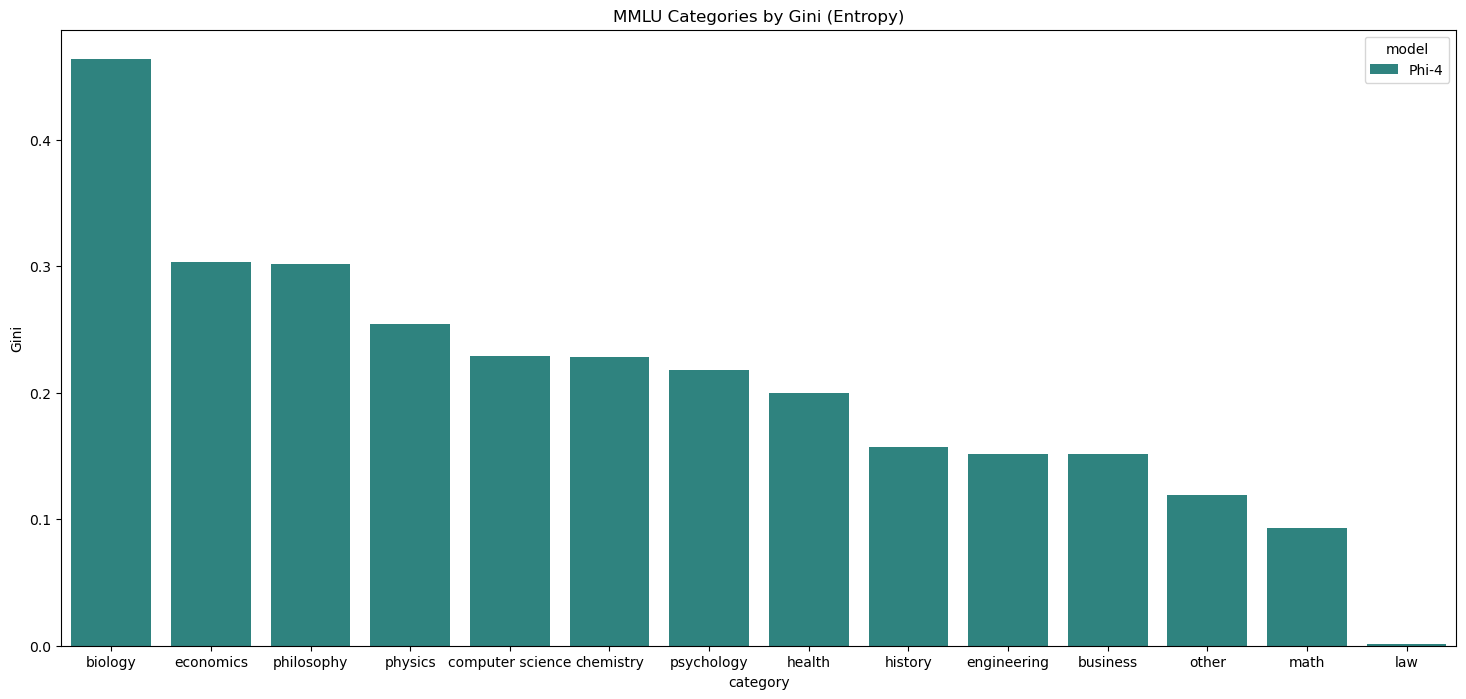

In [142]:
def plot_top_categories(df, metric_col, title):
    top_categories = df[
        (df['metric'] == metric_col) & 
        (df['category'] != 'ALL')
    ].sort_values(by='gini', ascending=False).head(15)

    plt.figure(figsize=(18, 8))
    sns.barplot(
        data=top_categories, 
        x='category', 
        y='gini', 
        hue='model',
        palette='viridis'
    )
    plt.title(f'MMLU Categories by Gini ({title})')
    plt.ylabel('Gini')
    plt.show()

plot_top_categories(final_results, 'entropy_value_phi3', 'Entropy')

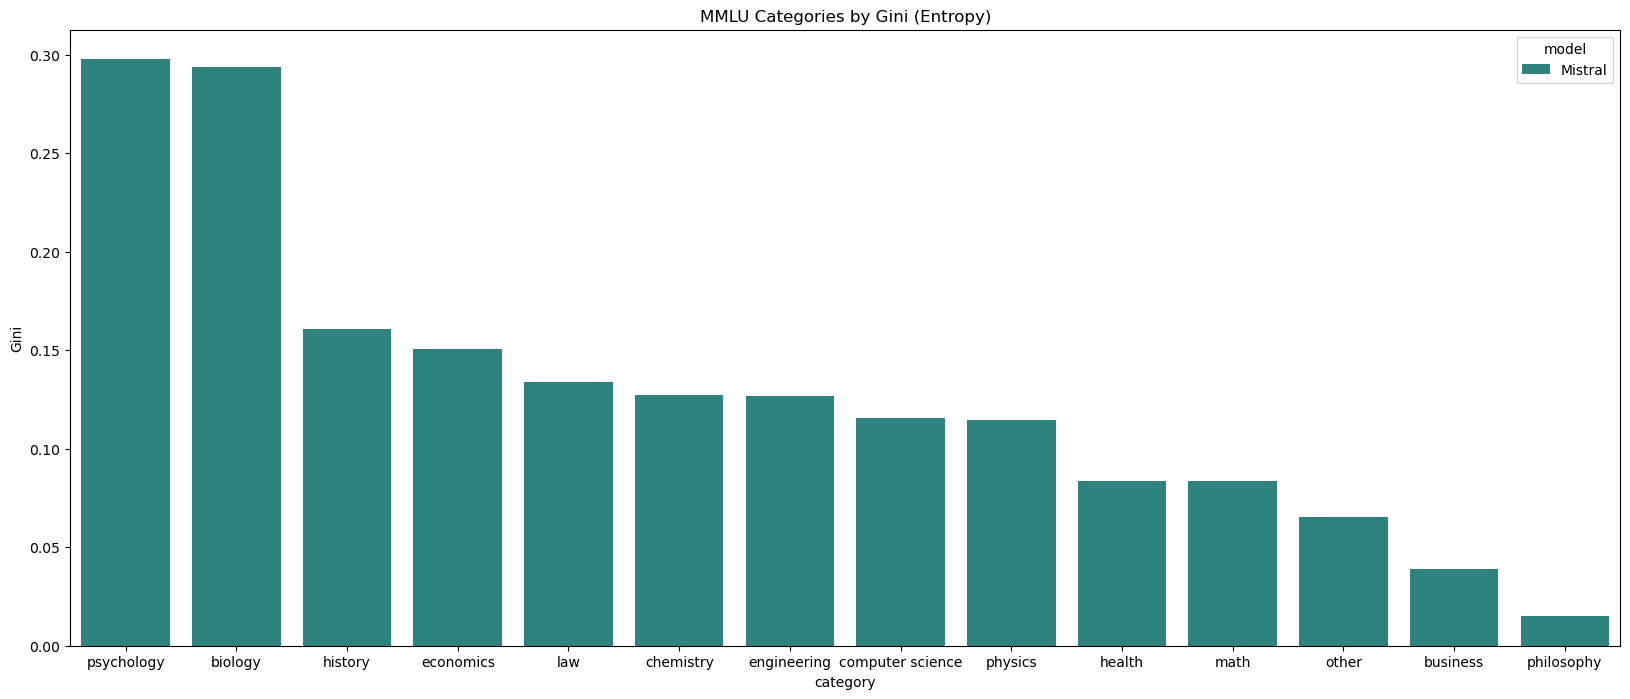

In [ ]:
plot_top_categories(final_results, 'field_entropy_value_mistral', 'Entropy')

In [ ]:
# Переделал функцию для категорий образования

def evaluate_question_model(df, model_name, target_col, score_col):
    """
    Анализирует метрики для каждой категории и общей выборки.
    """
    results = []
    
    # Для всех данных
    metrics = calculate_metrics(df[target_col], df[score_col])
    results.append({
        'category': 'ALL',
        'roc_auc': metrics['roc_auc'],
        'pr_auc': metrics['pr_auc'],
        'gini': metrics['gini'],
        'num_samples': len(df),
        'correct': df[target_col].sum(),
        'incorrect': len(df) - df[target_col].sum(),
        'model': model_name,
        'metric': score_col
    })
    
    # По категориям
    for category in df['masj_nominal_complexity'].unique():
        df_cat = df[df['masj_nominal_complexity'] == category]
        if len(df_cat) < 10:  # Пропустить категории с <10 примерами
            continue
            
        metrics = calculate_metrics(df_cat[target_col], df_cat[score_col])
        
        results.append({
            'category': category,
            'roc_auc': metrics['roc_auc'],
            'pr_auc': metrics['pr_auc'],
            'gini': metrics['gini'],
            'num_samples': len(df_cat),
            'correct': df_cat[target_col].sum(),
            'incorrect': len(df_cat) - df_cat[target_col].sum(),
            'model': model_name,
            'metric': score_col
        })
    
    return pd.DataFrame(results)

evaluate_question_model(phi_df, 'Phi-4', 'entropy_ans_correct_phi3', 'entropy_value_phi3').sort_values(by='gini', ascending=False)

,category,roc_auc,pr_auc,gini,num_samples,correct,incorrect,model,metric
5,phd,0.166667,0.163973,0.666667,11,3,8,Phi-4,entropy_value_phi3
4,middle_school,0.353967,0.372340,0.292066,627,286,341,Phi-4,entropy_value_phi3
3,high_school,0.377259,0.440773,0.245481,2743,1388,1355,Phi-4,entropy_value_phi3
0,ALL,0.416904,0.460342,0.166191,11052,5652,5400,Phi-4,entropy_value_phi3
2,undergraduate,0.425108,0.470889,0.149784,7071,3677,3394,Phi-4,entropy_value_phi3
1,postgraduate,0.468454,0.469022,0.063092,600,298,302,Phi-4,entropy_value_phi3


In [147]:
category_phi = evaluate_question_model(phi_df, 'Phi-4', 'entropy_ans_correct_phi3', 'entropy_value_phi3').sort_values(by='gini', ascending=False)

In [126]:
mistral_df['masj_nominal_complexity'] = mistral_df['question_id'].map(phi_df.set_index('question_id')['masj_nominal_complexity'])
mistral_df['masj_nominal_complexity'].value_counts()

masj_nominal_complexity
undergraduate    6628
high_school      2633
middle_school     624
postgraduate      578
phd                11
Name: count, dtype: int64

In [160]:
evaluate_question_model(mistral_df, 'Mistral', 'entropy_ans_correct_mistral', 'field_entropy_value_mistral').sort_values(by='gini', ascending=False)

,category,roc_auc,pr_auc,gini,num_samples,correct,incorrect,model,metric
5,phd,0.541667,0.268849,0.083333,11,3,8,Mistral,field_entropy_value_mistral
3,high_school,0.534895,0.499005,0.069790,2633,1317,1316,Mistral,field_entropy_value_mistral
1,postgraduate,0.533765,0.430963,0.067529,578,247,331,Mistral,field_entropy_value_mistral
0,ALL,0.520168,0.477212,0.040335,11407,5552,5855,Mistral,field_entropy_value_mistral
2,undergraduate,0.516249,0.481039,0.032499,6628,3265,3363,Mistral,field_entropy_value_mistral
4,middle_school,0.496569,0.412075,0.006861,624,274,350,Mistral,field_entropy_value_mistral


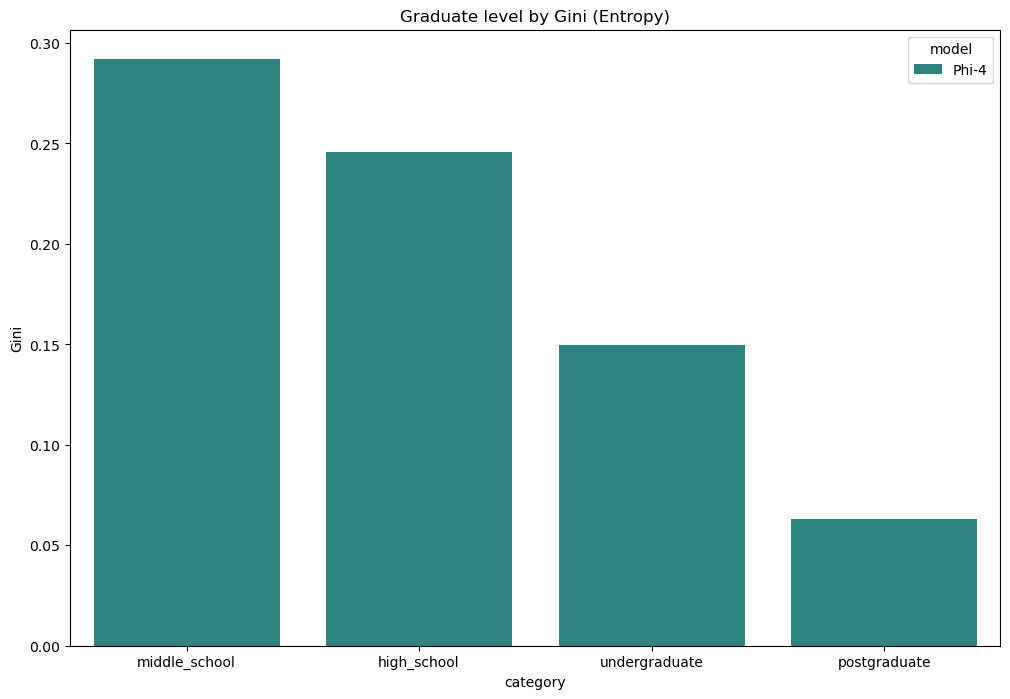

In [161]:
def plot_top_categories(df, metric_col, title):
    top_categories = df[
        (df['metric'] == metric_col) & 
        (df['category'] != 'phd') & (df['category'] != 'ALL')
    ].sort_values(by='gini', ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=top_categories, 
        x='category', 
        y='gini', 
        hue='model',
        palette='viridis'
    )
    plt.title(f'Graduate level by Gini ({title})')
    plt.ylabel('Gini')
    plt.show()

plot_top_categories(category_phi, 'entropy_value_phi3', 'Entropy')

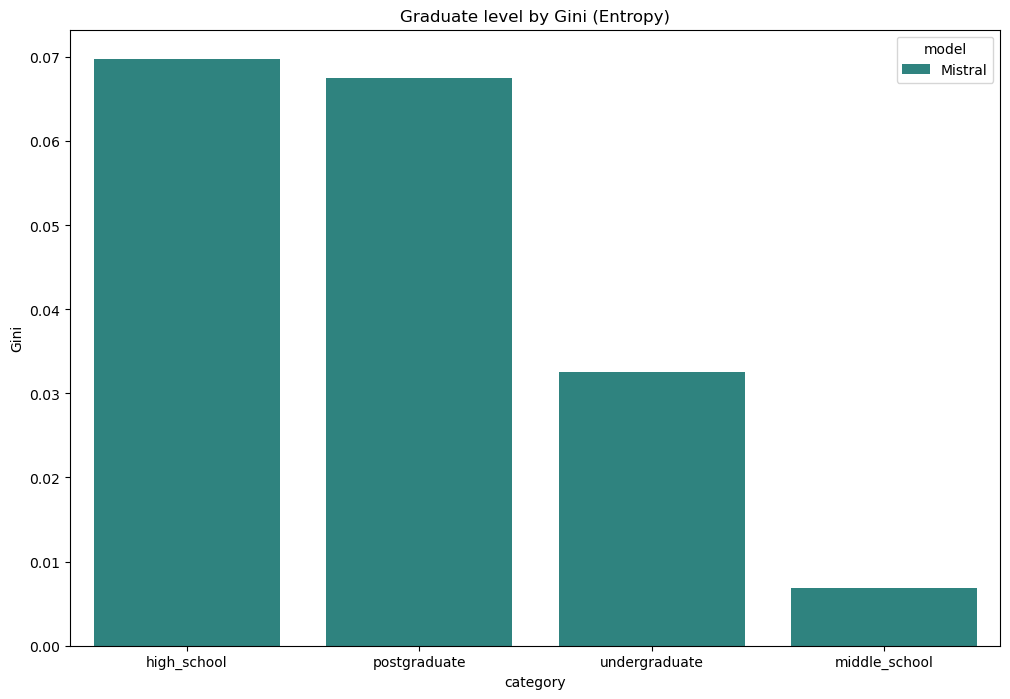

In [162]:
def plot_top_categories(df, metric_col, title):
    top_categories = df[
        (df['metric'] == metric_col) & 
        (df['category'] != 'phd') & (df['category'] != 'ALL')
    ].sort_values(by='gini', ascending=False).head(20)

    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=top_categories, 
        x='category', 
        y='gini', 
        hue='model',
        palette='viridis'
    )
    plt.title(f'Graduate level by Gini ({title})')
    plt.ylabel('Gini')
    plt.show()

plot_top_categories(category_mistral, 'field_entropy_value_mistral', 'Entropy')